## Dynamical analysis: Integrated quantities - Step 3

We want to compute the `Dynamical Structure Factor`, which is given by

$$ S_{\vec{q}}(w) = \sum_{n=1}^{nev} \left| \left\langle \Psi_n^X \left| \hat{S}_{\vec{q}}^{\alpha} \right| \Psi_0 \right\rangle \right| ^2 \delta(\omega - (E_n^X - E_0)) $$

$$ S_{\vec{q}}(w) = \sum_{n=1}^{nev} \left| \left\langle \Psi_n^X \left| \hat{S}_{\vec{q}}^{\alpha} \right| \Psi_0 \right\rangle \right| ^2 \frac{1}{\pi} \frac{\epsilon^2}{(\omega - (E_n^X - E_0))^2 + \epsilon^2} $$

Where

$$ \hat{S}_{\vec{q}}^{\alpha} = \frac{1}{\sqrt{L}} \sum_{i = 0}^{L-1} e^{i \vec{q} \cdot \vec{r}_i} \hat{S}_i^{\alpha} $$

So, we can rewrite the DSF as:
$$ S_{\vec{q}}(w) = \sum_{n=1}^{nev} \left| \left\langle \Psi_n^X \left| \frac{1}{\sqrt{L}} \sum_{i=0}^{L-1} e^{i \vec{q} \cdot \vec{r}_i} \hat{S}_i^{\alpha} \right| \Psi_0 \right\rangle \right| ^2 \frac{1}{\pi} \frac{\epsilon^2}{(\omega - (E_n^X - E_0))^2 + \epsilon^2} $$

$$ S_{\vec{q}}(w) = \sum_{n=1}^{nev} \left| \frac{1}{\sqrt{L}} \sum_{i=0}^{L-1} e^{i \vec{q} \cdot \vec{r}_i} \left\langle \Psi_n^X \left| \hat{S}_i^{\alpha} \right| \Psi_0 \right\rangle \right| ^2 \frac{1}{\pi} \frac{\epsilon^2}{(\omega - (E_n^X - E_0))^2 + \epsilon^2} $$

From the code we obtain a file with two columns: 
1. the first one, has the values of $ \Delta_n = E_n^X -E_0 $
2. the second one, has the values of the coefficient $ \left\langle \Psi_n^X \left| \hat{S}_i^{\alpha} \right| \Psi_0 \right\rangle $

### Integrated DSF

Now, what we want to compute is the integral of the DSF, $S_{\vec{q}}(w)$, up to some particular $w = w^*$, and study how this quantity changes with the value of $J_2$, for the antiferromagnetic state, $\vec{q} = (\pi, \pi)$, and the striped state, $\vec{q} = (0, \pi)$. We may also want to study these quantities depending on the value of $w^*$.

In [1]:
import numpy as np
import cmath as m
import matplotlib.pyplot as plt
import csv
import scipy.stats
from mpl_toolkits.mplot3d import axes3d
from matplotlib.collections import PolyCollection
#%matplotlib notebook

### Parameters

In [2]:
# Lattice

dim      = 2           # Dimension of the lattice
nspins   = [24]     # Number of spins in the system
nsp      = len(nspins)

rep      = 200         # Disorder realizations
nev      = 200         # Number of excited states used

In [3]:
# Reciprocal lattice

nQ       = nspins      # Number of q values to analyse
q_AF     = 15
q_STR    = 3

#pi       = np.arccos(-1)
#q_idx    = [i for i in range(nQ)]
#q_idxX   = [(i//Ly)*2*pi/Lx for i in q_idx]
#q_idxY   = [(i%Ly)*2*pi/Ly for i in q_idx]

#q_X      = [(i//Ly) for i in q_idx]
#q_Y      = [(i%Ly) for i in q_idx]

In [4]:
# Hamiltonian parameters

J1           = 1.0      # Nearest neighbours coupling
D1           = 1.0      # Nearest neighbours anisotropy
J2           = [0.40,0.44,0.50,0.54,0.60,0.64,0.70]      # Next-nearest neighbours coupling
D2           = 0.0      # Next-nearest neighbours anisotropy
dis_strength = [0.0,0.2,0.4,0.6,0.8,1.0]      # Strength of the disorder
#dis_strength = [0.1,0.2,0.3,0.4,0.5]      # Strength of the disorder

nJ2          = len(J2)
ndis_str     = len(dis_strength)

In [5]:
# Frequency parametes

nW       = 5001                # Number of frequency values to plot
w_min    = 0                   # Minimum value of frequency to plot
w_max    = 5                   # Maximum value of frequency to plot

w_star   = 2.2                 # Value of w until we integrate
_w_star  = int(w_star * 1000)  # Value of w until we integrate, scaled to our plots

In [6]:
# Files

root        = '/home/ale/MAIN24/'

pathINdata = np.empty((ndis_str,nsp,nJ2),dtype=object)
pathOUTdata = np.empty((ndis_str,nsp,nJ2),dtype=object)

for d in range(ndis_str):
    for n in range(nsp):    
        for j in range(nJ2):
            #pathINdata[d,n,j]  = '/home/ale/RUNS/dis' + str(dis_strength[d]) + '/' + str(nspins[n]) + 'nnn' + "{:2.2f}".format(J2[j]) + '/'
            pathINdata[d,n,j]  = root + 'dis' + str(dis_strength[d]) + '/' + str(nspins[n]) + 'nnn' + "{:2.2f}".format(J2[j]) + '/'
            pathOUTdata[d,n,j] = root + 'dis' + str(dis_strength[d]) + '/' + str(nspins[n]) + 'nnn' + "{:2.2f}".format(J2[j]) + '/'

### Prepare (full) data

In [7]:
if False:
    tmp_IqAF = np.zeros((ndis_str,nsp,nJ2,rep))
    tmp_IqSTR = np.zeros((ndis_str,nsp,nJ2,rep))

    for d in range(1,ndis_str):
        for n in range(nsp):
            tmp_Sw = np.zeros((rep,nQ[n],nW))
            for j in range(nJ2):

                # 1. Read data from file
                for dis_rep in range(rep):
                    with open(pathINdata[d,n,j] + 'Sq/Sq_' + str(dis_rep) + '.csv') as dis_csvfile:
                        tmp_read_Sw_dis = np.genfromtxt(dis_csvfile)
                    tmp_Sw[dis_rep,:,:] = tmp_read_Sw_dis[:,1:].T

                # 2. Compute integrated quantities
                for wi in range(_w_star):
                    tmp_IqAF[d,n,j,:]  += tmp_Sw[:,q_AF,wi]
                    tmp_IqSTR[d,n,j,:] += tmp_Sw[:,q_STR,wi]

In [8]:
if False:
    # Cumulatice values
    check_IqAF  = np.zeros((ndis_str,nsp,nJ2,rep))
    check_IqSTR = np.zeros((ndis_str,nsp,nJ2,rep))

    for dis_rep in range(rep):
        check_IqAF[:,:,:,dis_rep]  = check_IqAF[:,:,:,dis_rep-1] + tmp_IqAF[:,:,:,dis_rep]
        check_IqSTR[:,:,:,dis_rep] = check_IqSTR[:,:,:,dis_rep-1] + tmp_IqSTR[:,:,:,dis_rep]

    for dis_rep in range(1,rep):
        check_IqAF[:,:,:,dis_rep]  /= (dis_rep+1)
        check_IqSTR[:,:,:,dis_rep] /= (dis_rep+1)

In [9]:
if True:
    # Read tmp_IqAF and tmp_IqSTR from file

    IqAF_err = np.zeros((ndis_str,nsp,nJ2,4))

    IqAF_err[1,0,0,:] = [17.89656116,1.27256914,18.22750297,0.5091604 ]
    IqAF_err[1,0,1,:] = [20.07017434,0.60302264,20.01874878,0.37741893]
    IqAF_err[1,0,2,:] = [20.65133173,0.58405705,20.60279543,0.32469259]
    IqAF_err[1,0,3,:] = [17.36028173,0.45660408,17.33609949,0.27696817]
    IqAF_err[1,0,4,:] = [10.56866497,0.23145431,10.59180003,0.13354431]
    IqAF_err[1,0,5,:] = [7.38241577,0.09171899,7.38425536,0.05698015]
    IqAF_err[1,0,6,:] = [5.69369696,0.08188011,5.69550002,0.04613054]

    IqAF_err[2,0,0,:] = [16.10573369,1.96366568,16.1706789,1.28550777]
    IqAF_err[2,0,1,:] = [19.26970969,1.48161664,19.24340513,0.8453635 ]
    IqAF_err[2,0,2,:] = [19.48931915,1.42788174,19.5502548,0.76668076]
    IqAF_err[2,0,3,:] = [16.81393868,1.0505475,16.85222666,0.62383848]
    IqAF_err[2,0,4,:] = [10.05145677,0.60349122,10.14035992,0.34070642]
    IqAF_err[2,0,5,:] = [7.28881898,0.22654694,7.2961307,0.11640501]
    IqAF_err[2,0,6,:] = [5.55749352,0.22587181,5.61603908,0.10723978]

    IqAF_err[3,0,0,:] = [14.95272678,2.39226761,14.63891289,1.43140837]
    IqAF_err[3,0,1,:] = [16.93805099,2.81063951,17.16039662,1.68859437]
    IqAF_err[3,0,2,:] = [16.20279689,3.11285022,16.27337562,1.98290332]
    IqAF_err[3,0,3,:] = [14.92060301,2.55407113,15.26885222,1.30471307]
    IqAF_err[3,0,4,:] = [9.13436493,0.96974391,9.12592515,0.62218944]
    IqAF_err[3,0,5,:] = [6.93616022,0.54519082,7.04855799,0.24501329]
    IqAF_err[3,0,6,:] = [5.23885713,0.41437049,5.33904042,0.25798456]

    IqAF_err[4,0,0,:] = [14.01618583,2.98323806,13.43958279,1.55852636]
    IqAF_err[4,0,1,:] = [14.63091755,3.85688196,13.75627698,2.26426712]
    IqAF_err[4,0,2,:] = [13.11300988,4.5743173,12.31984014,2.65687859]
    IqAF_err[4,0,3,:] = [10.29700745,4.82969609,9.41848644,2.71978058]
    IqAF_err[4,0,4,:] = [7.53229211,1.42980184,7.38106053,0.81766528]
    IqAF_err[4,0,5,:] = [6.34988522,0.65167304,6.31328318,0.40230138]
    IqAF_err[4,0,6,:] = [4.97719311,0.45928993,4.94978214,0.28943648]

    IqAF_err[5,0,0,:] = [11.77970659,4.85405157,11.35537122,2.3948801 ]
    IqAF_err[5,0,1,:] = [10.69390869,5.85120834,9.98797662,3.38997317]
    IqAF_err[5,0,2,:] = [8.44406284,6.45483491,6.30948836,3.09522625]
    IqAF_err[5,0,3,:] = [7.13241587,6.04535862,4.90050688,2.26511134]
    IqAF_err[5,0,4,:] = [6.48654117,3.31795888,5.63019497,1.40055747]
    IqAF_err[5,0,5,:] = [6.26404756,2.22819727,5.85030226,0.73381735]
    IqAF_err[5,0,6,:] = [5.13588923,0.88290708,5.05107855,0.37239081]

In [10]:
if True:
    IqSTR_err = np.zeros((ndis_str,nsp,nJ2,4))

    IqSTR_err[1,0,0,:] = [4.05109677,0.08680701,4.04254444,0.05563785]
    IqSTR_err[1,0,1,:] = [2.34608407,0.10803876,2.34929509,0.06418449]
    IqSTR_err[1,0,2,:] = [0.22371265,0.03381375,0.22074999,0.02042426]
    IqSTR_err[1,0,3,:] = [0.21418156,0.02717018,0.21325064,0.0165009 ]
    IqSTR_err[1,0,4,:] = [3.81063282,0.07861311,3.81362388,0.04925813]
    IqSTR_err[1,0,5,:] = [6.33871004,0.0585224,6.3370303,0.03666172]
    IqSTR_err[1,0,6,:] = [8.24902493,0.05463836,8.2541644,0.029824  ]

    IqSTR_err[2,0,0,:] = [4.17939568,0.2045731,4.16052788,0.11560479]
    IqSTR_err[2,0,1,:] = [2.38513369,0.21794911,2.3454228,0.12210318]
    IqSTR_err[2,0,2,:] = [0.29870241,0.08847977,0.28134207,0.04816881]
    IqSTR_err[2,0,3,:] = [0.20291411,0.04656045,0.19849909,0.02692424]
    IqSTR_err[2,0,4,:] = [3.72301577,0.15869899,3.72133752,0.0979543 ]
    IqSTR_err[2,0,5,:] = [6.24381045,0.27164937,6.26098875,0.07221563]
    IqSTR_err[2,0,6,:] = [8.04071686,0.54893915,8.1468395,0.0763204 ]

    IqSTR_err[3,0,0,:] = [4.35705442,0.32506939,4.31522929,0.19158606]
    IqSTR_err[3,0,1,:] = [2.60117446,0.32982513,2.53724186,0.18526846]
    IqSTR_err[3,0,2,:] = [0.48657128,0.253054,0.41326919,0.09828517]
    IqSTR_err[3,0,3,:] = [0.21237478,0.08626667,0.19736703,0.0360491 ]
    IqSTR_err[3,0,4,:] = [3.43936791,0.29816977,3.48479799,0.15395074]
    IqSTR_err[3,0,5,:] = [5.64848781,1.3180123,6.09740706,0.13366392]
    IqSTR_err[3,0,6,:] = [6.91585045,1.82212156,7.90283443,0.24680634]

    IqSTR_err[4,0,0,:] = [4.53491146,0.5534864,4.42301636,0.26757158]
    IqSTR_err[4,0,1,:] = [3.07741416,1.02799589,2.82723042,0.29796221]
    IqSTR_err[4,0,2,:] = [1.17734945,1.2682158,0.7446508,0.28784411]
    IqSTR_err[4,0,3,:] = [0.93205737,2.15550289,0.25230942,0.08302009]
    IqSTR_err[4,0,4,:] = [3.16178109,1.30142858,2.9966333,0.35262919]
    IqSTR_err[4,0,5,:] = [4.2724391,2.18075882,5.17398386,1.06783877]
    IqSTR_err[4,0,6,:] = [4.85552879,2.35297971,4.29020277,1.86640251]

    IqSTR_err[5,0,0,:] = [4.99316947,1.99120089,4.52389454,0.50961091]
    IqSTR_err[5,0,1,:] = [4.34703559,2.28953528,3.48785603,0.71249302]
    IqSTR_err[5,0,2,:] = [4.18349902,4.61474376,2.68454578,1.16671873]
    IqSTR_err[5,0,3,:] = [3.96860956,4.19976533,2.39046228,1.20842935]
    IqSTR_err[5,0,4,:] = [4.40213676,4.26291707,2.67174114,1.06491146]
    IqSTR_err[5,0,5,:] = [4.11588562,2.78577534,3.26559865,1.10040468]
    IqSTR_err[5,0,6,:] = [4.30327563,3.37283715,3.12925491,1.00436054]

### Prepare (reduced) data

In [11]:
# Data
IqAF  = np.zeros((ndis_str,nsp,nJ2))
IqSTR = np.zeros((ndis_str,nsp,nJ2))

for d in range(ndis_str):
    for n in range(nsp):
        #Sw = np.zeros((nW,nQ[n]))
        for j in range(nJ2):
           
            # 1. Read data from file
            with open(pathINdata[d,n,j] + 'Sq.csv') as csvfile:
                tmp_read_Sw = np.genfromtxt(csvfile)
            Sw = tmp_read_Sw[:,1:]
            
            # 2. Compute integrated quantities
            for wi in range(_w_star):
                IqAF[d,n,j]  += Sw[wi,q_AF]
                IqSTR[d,n,j] += Sw[wi,q_STR]

if False:
    # Error
    IqAF_err  = np.empty((ndis_str,nsp,nJ2,4))
    IqSTR_err = np.empty((ndis_str,nsp,nJ2,4))

    for d in range(1,ndis_str):
        for n in range(nsp):
            for j in range(nJ2):
                histAF, binsAF = np.histogram(tmp_IqAF[d,n,j,:], bins=32, density=True)
                IqAF_err[d,n,j,0:2] = scipy.stats.norm.fit(tmp_IqAF[d,n,j,:])
                IqAF_err[d,n,j,2:4] = scipy.stats.cauchy.fit(tmp_IqAF[d,n,j,:])

                histSTR, binsSTR = np.histogram(tmp_IqSTR[d,n,j,:], bins=32, density=True)
                IqSTR_err[d,n,j,0:2] = scipy.stats.norm.fit(tmp_IqSTR[d,n,j,:])
                IqSTR_err[d,n,j,2:4] = scipy.stats.cauchy.fit(tmp_IqSTR[d,n,j,:])

### Plot vs J2

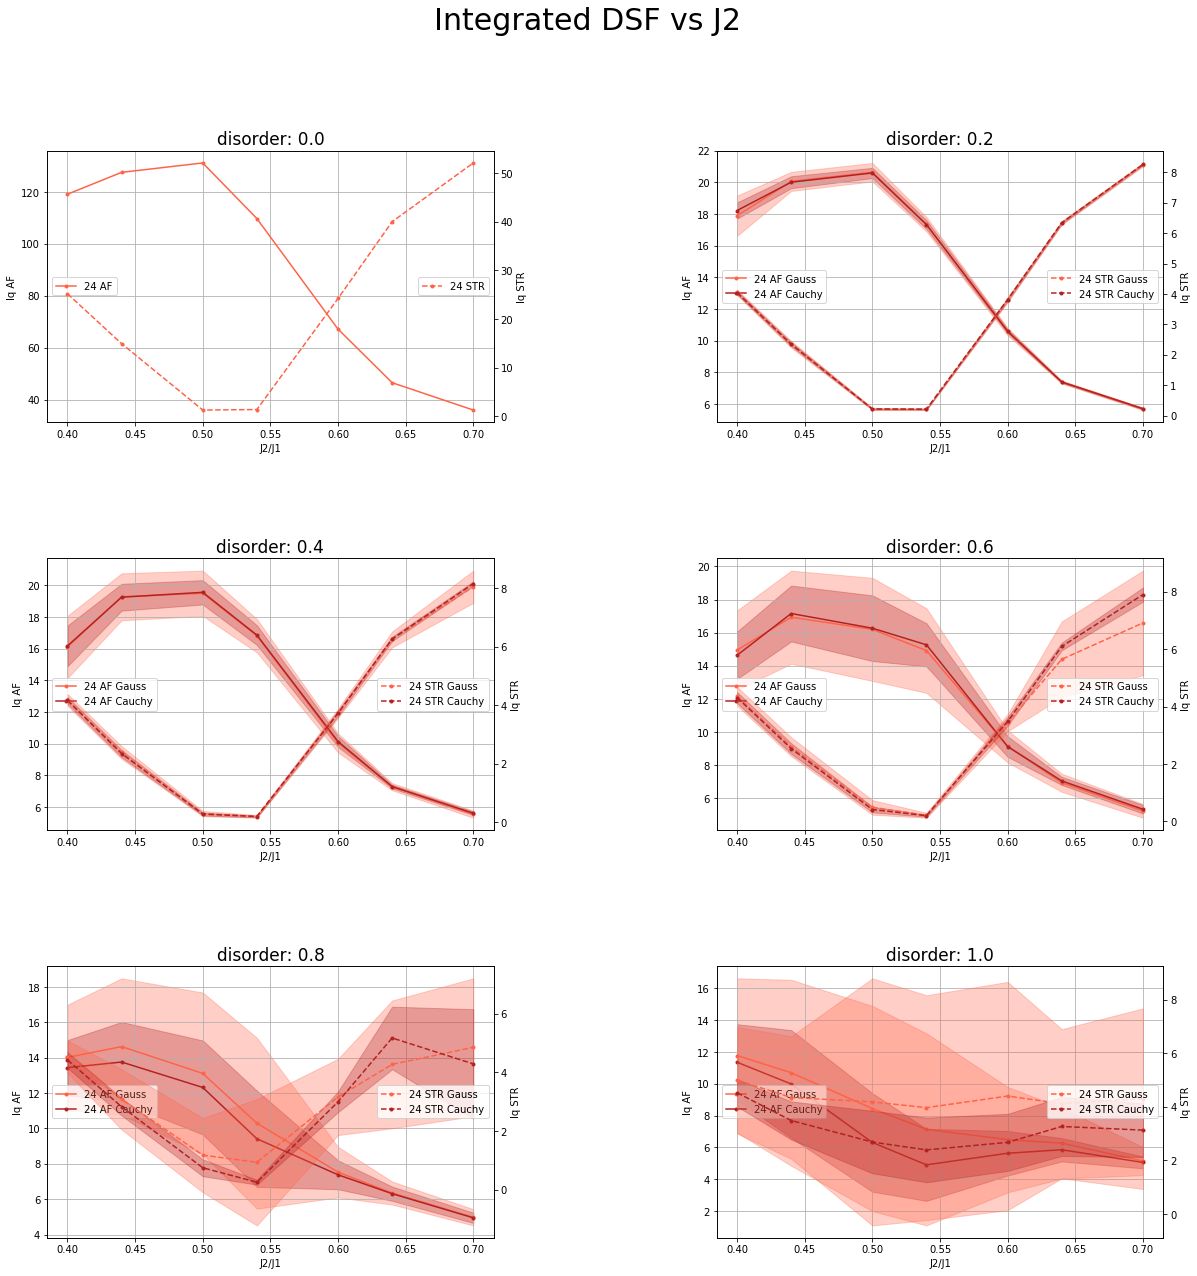

In [16]:
# Colors
col_norm    = ['tomato','mediumseagreen','goldenrod','royalblue']
col_cauchy  = ['firebrick','darkgreen','orange','navy']

fig, ax1 = plt.subplots(3,2,gridspec_kw={'wspace':0.5, 'hspace': 0.5},figsize=(20,20))
fig.suptitle("Integrated DSF vs J2", fontsize=30)

for x in range(3):
    for y in range(2):
        
        if (x*2+y >= len(dis_strength)):
            break
        
        ax1[x,y].set_title("disorder: " + str(dis_strength[x*2+y]), fontsize=17)
        ax1[x,y].set_xlabel("J2/J1")
        ax1[x,y].set_ylabel("Iq AF")
        ax1[x,y].grid()
        ax2= ax1[x,y].twinx()
        ax2.set_ylabel("Iq STR")

        for n in range(nsp):
            
            if x == 0 and y == 0:
                ax1[x,y].plot(J2,IqAF[x*2+y,n,:],col_norm[n],marker='.',ls='-',label=str(nspins[n])+' AF')
                ax2.plot(J2,IqSTR[x*2+y,n,:],col_norm[n],marker='.',ls='--',label=str(nspins[n])+' STR')
                
            else:
                #ax1[x,y].plot(J2,IqAF[x*2+y,n,:]/rep,col_norm[n],marker='.',ls='-',label=str(nspins[n])+' AF Gauss')
                ax1[x,y].plot(J2,IqAF_err[x*2+y,n,:,0],col_norm[n],marker='.',ls='-',label=str(nspins[n])+' AF Gauss')
                ax1[x,y].fill_between(J2,IqAF_err[x*2+y,n,:,0]-IqAF_err[x*2+y,n,:,1],IqAF_err[x*2+y,n,:,0]+IqAF_err[x*2+y,n,:,1],alpha=0.3,color=col_norm[n])
                #ax2.plot(J2,IqSTR[x*2+y,n,:]/rep,col_norm[n],marker='.',ls='--',label=str(nspins[n])+' STR Gauss')
                ax2.plot(J2,IqSTR_err[x*2+y,n,:,0],col_norm[n],marker='.',ls='--',label=str(nspins[n])+' STR Gauss')
                ax2.fill_between(J2,IqSTR_err[x*2+y,n,:,0]-IqSTR_err[x*2+y,n,:,1],IqSTR_err[x*2+y,n,:,0]+IqSTR_err[x*2+y,n,:,1],alpha=0.3,color=col_norm[n])

                #ax1[x,y].plot(J2,IqAF[x*2+y,n,:]/rep,col_cauchy[n],marker='.',ls='-',label=str(nspins[n])+' AF Cauchy')
                ax1[x,y].plot(J2,IqAF_err[x*2+y,n,:,2],col_cauchy[n],marker='.',ls='-',label=str(nspins[n])+' AF Cauchy')
                ax1[x,y].fill_between(J2,IqAF_err[x*2+y,n,:,2]-IqAF_err[x*2+y,n,:,3],IqAF_err[x*2+y,n,:,2]+IqAF_err[x*2+y,n,:,3],alpha=0.3,color=col_cauchy[n])
                #ax2.plot(J2,IqSTR[x*2+y,n,:]/rep,col_cauchy[n],marker='.',ls='--',label=str(nspins[n])+' STR Cauchy')
                ax2.plot(J2,IqSTR_err[x*2+y,n,:,2],col_cauchy[n],marker='.',ls='--',label=str(nspins[n])+' STR Cauchy')
                ax2.fill_between(J2,IqSTR_err[x*2+y,n,:,2]-IqSTR_err[x*2+y,n,:,3],IqSTR_err[x*2+y,n,:,2]+IqSTR_err[x*2+y,n,:,3],alpha=0.3,color=col_cauchy[n])
            
            ax1[x,y].legend(loc='center left')
            ax2.legend(loc='center right')

plot_name = root + 'plots/integrDSF'+ str(nspins[0]) + '.pdf'
        
fig.savefig(plot_name)

### Check distribution of data

NameError: name 'tmp_IqAF' is not defined

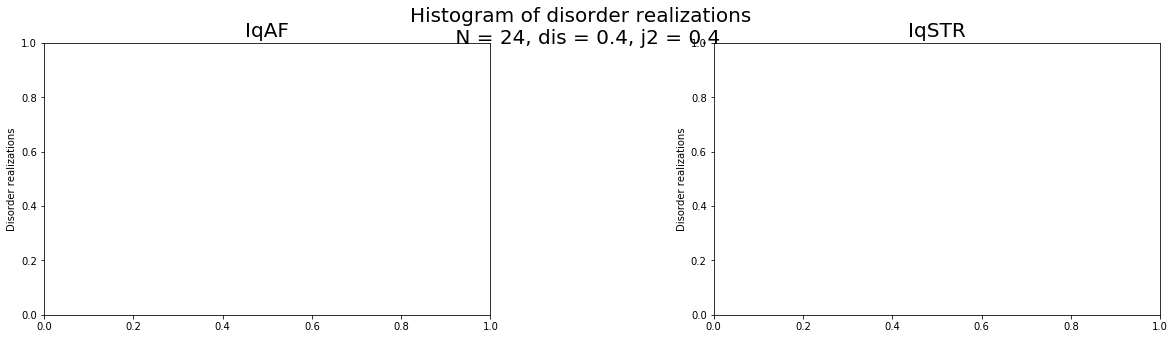

In [13]:
this_spin = 0
this_dis  = 2
this_j2   = 0

title = "Histogram of disorder realizations \n N = " + str(nspins[this_spin]) + ', dis = ' + str(dis_strength[this_dis]) + ', j2 = ' + str(J2[this_j2])

# Check histogram
fig, ax = plt.subplots(1,2,gridspec_kw={'wspace':0.5, 'hspace': 0.5}, figsize=(20,5))
fig.suptitle(title, fontsize=20)

ax[0].set_title("IqAF", fontsize=20)
ax[0].set_ylabel("Disorder realizations")
ax[1].set_title("IqSTR", fontsize=20)
ax[1].set_ylabel("Disorder realizations")

histAF, binsAF, patchesAF    = ax[0].hist(tmp_IqAF[this_dis,this_spin,this_j2,:], bins=32, density=True,label="data")
histSTR, binsSTR, patchesSTR = ax[1].hist(tmp_IqSTR[this_dis,this_spin,this_j2,:], bins=32, density=True,label="data")

# Fit the distribution
meanAF, varAF = scipy.stats.norm.fit(tmp_IqAF[this_dis,this_spin,this_j2,:])
xAF = np.linspace(binsAF[0],binsAF[32],100)
pAF = scipy.stats.norm.pdf(xAF,meanAF,varAF)
ax[0].plot(xAF,pAF,'k',label='fit-gauss',color='b')
ax[0].legend()
#ax[0].text(0.3,20,'mean: {:2.4f}'.format(meanAF) + '\n' + 'std: {:2.4f}'.format(m.sqrt(varAF).real))

meanAF, stdAF = scipy.stats.cauchy.fit(tmp_IqAF[this_dis,this_spin,this_j2,:])
xAF = np.linspace(binsAF[0],binsAF[32],100)
pAF = scipy.stats.cauchy.pdf(xAF,meanAF,stdAF)
ax[0].plot(xAF,pAF,'k',label='fit-cauchy',color='g')
ax[0].legend()

meanSTR, varSTR = scipy.stats.norm.fit(tmp_IqSTR[this_dis,this_spin,this_j2,:])
xSTR = np.linspace(binsSTR[0],binsSTR[32],100)
pSTR = scipy.stats.norm.pdf(xSTR,meanSTR,varSTR)
ax[1].plot(xSTR,pSTR,'k',label="fit-gauss")
ax[1].legend()
#ax[1].text(0.25,25,'mean: {:2.4f}'.format(meanSTR) + '\n' + 'std: {:2.4f}'.format(m.sqrt(varSTR).real))

meanSTR, stdSTR = scipy.stats.cauchy.fit(tmp_IqSTR[this_dis,this_spin,this_j2,:])
xAF = np.linspace(binsAF[0],binsAF[32],100)
pAF = scipy.stats.cauchy.pdf(xSTR,meanSTR,stdSTR)
ax[1].plot(xSTR,pSTR,'k',label='fit-cauchy',color='g')
ax[1].legend()

plot_name = root + 'plots/distrib' + str(nspins[0]) + '.pdf'
        
fig.savefig(plot_name)

### Check convergibility

In [ ]:
# Plot the cummulative values
d = np.linspace(0,rep-1,rep)

fig, ax = plt.subplots(1,2,gridspec_kw={'wspace':0.5, 'hspace': 0.5}, figsize=(20,5))
fig.suptitle("Convergence according to disorder realizations N = " + str(nspins[this_spin]), fontsize=20)

ax[0].set_title("IqAF", fontsize=20)
ax[0].set_xlabel("Disorder realizations")
ax[0].plot(d,check_IqAF[this_dis,this_spin,this_j2,:])
ax[1].set_title("IqSTR", fontsize=20)
ax[1].set_xlabel("Disorder realizations")
ax[1].plot(d,check_IqSTR[this_dis,this_spin,this_j2,:])

plot_name = root + 'plots/converg' + str(nspins[0]) + '.pdf'
        
fig.savefig(plot_name)